# **Анализ данных национального виктимизационного опроса**

# Данный проект посвящен изучению преступности на территории Российской Федерации. Цель работы – выяснить, как влияют социально-демографические характеристики человека на его возможность оказаться жертвой преступления (виктимность).
>##### Данные для анализа собраны Институтом проблем правоприменения (ИПП) при ЕУ СПб и представляют результаты телефонного опроса респондентов не моложе 18 лет на основании простой случайной выборки телефонных номеров. Респонденты опрашивались независимо от гражданства, но, по понятным причинам, большинство (98.1%) были гражданами РФ. Вопросы делились на анкетные (пол, возраст, социо-демографический профиль), основной («были ли жертвой преступления») и уточняющие вопросы о преступлениях (где, когда и т.п.). Анкета составлена специальным образом профессионалами, учитывая многие особенности, например специфику русского языка.
# Задачи данного исследования:
*   Ознакомиться с форматом данных, осуществить их предобработку.
*   Сделать анализ данных опроса жителей РФ о преступлениях, жертвами которых они становились.
*   Визуализировать найденные закономерности.
*   Исходя из выявленных зависимостей, построить классификационную модель, определяющую виктимность человека.





## Структура проекта



---


1.   [***Импорт необходимых библиотек***](#Импорт-необходимых-библиотек)
2.   [***Загрузка и предварительная обработка данных***](#Загрузка-и-предварительная-обработка-данных)
3.   [***Был ли респодент жертвой преступления?***](#Был-ли-респодент-жертвой-преступления?)
4.   [***Анализ выборки лиц, являющихся жертвами преступлений***](#Анализ-выборки-лиц,-являющихся-жертвами-преступлений)
    1.   [***Анализ влияния полового признака на совершение преступлений и подверженность им***](#Анализ-влияния-полового-признака-на-совершение-преступлений-и-подверженность-им)
    2.   [***Был ли найден нападавший?***](#Был-ли-найден-нападавший?)
    3.   [***Была ли необходима медицинская помощь?***](#Была-ли-необходима-медицинская-помощь?)
    4.   [***Был ли нападавший при исполнении?***](#Был-ли-нападавший-при-исполнении?)
    5.   [***Анализ частоты видов преступлений***](#Анализ-частоты-видов-преступлений)
    6.   [***Анализ влияния возраста на подверженность преступлениям***](#Анализ-влияния-возраста-на-подверженность-преступлениям)
    7.   [***Анализ влияния дохода на подверженность преступлениям***](#Анализ-влияния-дохода-на-подверженность-преступлениям)
    8.   [***Анализ влияния образования на подверженность преступлениям***](#Анализ-влияния-образования-на-подверженность-преступлениям)
    9.   [***Анализ влияния социально-экономического статуса на подверженность преступлениям***](#Анализ-влияния-социально–экономического-статуса-на-подверженность-преступлениям)
    10.   [***Анализ скорости реагирования правоохранителей***](#Анализ-скорости-реагирования-правоохранителей)
    11.   [***Анализ материального ущерба пострадавших***](#Анализ-материального-ущерба-пострадавших)
    12.   [***Анализ зависимости вида преступлений от времени суток***](#Анализ-зависимости-вида-преступлений-от-времени-суток)
    13.   [***Идеальный портрет человека, являющегося жертвой преступления***](#Составим-идеальный-портрет-человека,-являющегося-жертвой-преступления)
5.   [***Анализ выборки лиц, не являющихся жертвами преступлений***](#Анализ-выборки-лиц,-не-являющихся-жертвами-преступлений)
    1.   [***Анализ полового признака***](#Анализ-полового-признака)
    2.   [***Анализ возраста***](#Анализ-возраста)
    3.   [***Анализ уровня дохода***](#Анализ-уровня-дохода)
    4.   [***Анализ уровня образования***](#Анализ-уровня-образования)
    5.   [***Анализ социально-экономического статуса***](#Анализ-социально–экономического-статуса)
    6.   [***Идеальный портрет человека, не являющегося жертвой преступления***](#Составим-идеальный-портрет-человека,-не-являющегося-жертвой-преступления)
6.   [***Сравнение выборок из лиц, являющихся жертвами преступлений и лиц, не являющихся жертвами преступлений***](Сравнение-выборок-из-лиц,-являющихся-жертвами-преступлений-и-лиц,-не-являющихся-жертвами-преступлений)
    1.   [***Сравнение по половому признаку***](#Сравнение-по-половому-признаку)
    2.   [***Сравнение по возрасту***](#Сравнение-по-возрасту)
    3.   [***Сравнение по уровню дохода***](#Сравнение-по-уровню-дохода)
    4.   [***Сравнение по уровню образования***](#Сравнение-по-уровню-образования)
    5.   [***Сравнение по социально-экономическому статусу***](#Сравнение-по-социально–экономическому-статусу)
    6.   [***Общий вывод из сравнения выборок***](#Общий-вывод-из-сравнения-выборок)
7.   [***Классификационная модель***](#Классификационная-модель)
    1.   [***Создание необходимых выборок***](#Создание-необходимых-выборок)
    2.   [***Создание модели***](#Создание-модели)
    3.   [***Обучение модели***](#Обучение-модели)
    4.   [***Расчет точности модели и кросс-валидация***](#Расчет-точности-модели-и-кросс–валидация)
    5.   [***Применение модели к случайным данным***](#Применение-модели-к-случайным-данным)
    6.   [***Применение модели к идеальным портретам лиц, являющихся и не являющихся жертвами преступлений***](#Применение-модели-к-идеальным-портретам-лиц,-являющихся-и-не-являющихся-жертвами-преступлений)
    7.   [***Вывод по построению классификационной модели***](#Вывод-по-построению-классификационной-модели)
8.   [***Результаты проделанной работы***](#Результаты-проделанной-работы)
---





## Импорт и установка необходимых библиотек и виджетов

Установка библиотек

In [123]:
%%capture
!pip install catboost
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install sklearn
!pip install tensorflow
!pip install scipy
!pip install seaborn

Установка и включение виджетов

In [124]:
%%capture
!pip install ipywidgets
!pip install ipython
!jupyter nbextension enable --py widgetsnbextension

Импорт библиотек

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras.utils import get_file as getfile  # Используется для того, чтобы скачать датасет напрямую
import matplotlib.patches as mpatches
from scipy import stats as st
from copy import copy
import seaborn as sns
import math
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Загрузка и предварительная обработка данных

*После изучения данных и рекомендаций в [технической документации к данным](https://globaldataversecommunityconsortium.github.io/dataverse-previewers/previewers/PDFPreview.html?fileid=3441892&siteUrl=https://dataverse.harvard.edu&datasetid=3382060&datasetversion=5.0&locale=en) было принято решение использовать **только сконструированные переменные**, которые не несут в себе субъективных оценок респондента и являются необходимыми для анализа, добавив к ним переменные:*

*   **offender_is_on_duty** – был ли преступник должностным лицом или при исполнении (логическая переменная)





**Загрузка файла с серверов Гарварда**

In [126]:
# Загрузка файла с серверов Гарварда
dataset_path = getfile("dataset.csv", "https://dataverse.harvard.edu/api/access/datafile/3676762?format=original&gbrecs=true")

Преобразовываем данные в датафрейм


In [127]:
raw_dataset = pd.read_csv(dataset_path)
df = raw_dataset.copy()
df.head()

,ID,IVDur,Q1,Q2,Q75,Q75_1N,Q76,Q76_1N,Q5_1T,Q66,...,victim_is_compensated,victim_is_reconciliation,victim_is_told_anyone,offender_is_male,offender_is_on_duty,offender_is_alone,offender_is_familiar,offender_is_drug_intoxicated,offender_relationship,offender_relationship_grouped
0,12646573,544,1,57,1,2.0,2.0,NaN,полтора года тому назад,1.0,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12658422,1643,1,59,1,4.0,1.0,2.0,открытый грабеж-выхватили сумку с документами ...,2.0,...,0.0,0.0,1.0,1.0,NaN,0.0,0.0,0.0,8.0,6.0
2,12660336,676,1,35,1,1.0,2.0,NaN,"покупка на авито ,мы отправили деньги ,но нам...",1.0,...,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12664831,510,1,22,1,1.0,2.0,NaN,украли телефон,2.0,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12666214,1107,1,79,1,3.0,2.0,NaN,"мошенничество,говорят и звонят я твой сын и до...",1.0,...,0.0,NaN,1.0,1.0,NaN,1.0,0.0,0.0,8.0,6.0


Проверим выборку на дубликаты

In [128]:
df_duplicates = df.loc[df.duplicated()]

print('В выборке содержится {} дубликатов'.format(len(df_duplicates)))

В выборке содержится 0 дубликатов


Добавляем указанные переменные и удаляем сконструированные переменные, несущие в себе субъективные оценки корреспондента / неиспользуемые в анализе данных

In [129]:
df['offender_is_on_duty'] = df['Q12']

cols = ['resp_is_crime_victim','resp_is_male', 'resp_age',
       'resp_income', 'resp_edu', 'resp_ses',
       'crime_is_violent_damage', 'crime_is_seeking_medical_help',
       'crime_type', 'crime_is_daytime', 'victim_damage_rub',
       'victim_police_reaction_time', 'victim_is_offender_found',
       'offender_is_male', 'offender_is_on_duty']

df = df[cols]

Создаем переменные, содержащие цвета для последующего использования при построении графиков в едином стиле

In [130]:
colors = ['powderblue',
          'steelblue',
          'deepskyblue',
          'lightblue',
          'darkturquoise',
          'cadetblue',
          'teal']

pltclr = 'silver'
digclr = 'whitesmoke'

Проведем настройку библиотеки ***Pandas***, в частности отключим предупреждение о копировании данных

In [131]:
pd.options.mode.chained_assignment = None  # default='warn'

***Итоговый вид данных после исходной предобработки:***




In [132]:
df.head()

,resp_is_crime_victim,resp_is_male,resp_age,resp_income,resp_edu,resp_ses,crime_is_violent_damage,crime_is_seeking_medical_help,crime_type,crime_is_daytime,victim_damage_rub,victim_police_reaction_time,victim_is_offender_found,offender_is_male,offender_is_on_duty
0,1,0,57,3.0,3.0,2.0,0.0,0.0,6.0,1.0,300.0,NaN,0.0,NaN,NaN
1,1,0,59,NaN,3.0,2.0,0.0,0.0,3.0,1.0,80000.0,1.0,1.0,1.0,NaN
2,1,0,35,NaN,3.0,1.0,0.0,0.0,6.0,1.0,3000.0,NaN,1.0,NaN,NaN
3,1,0,22,3.0,3.0,3.0,0.0,0.0,5.0,1.0,7000.0,1.0,0.0,NaN,NaN
4,1,0,79,1.0,3.0,2.0,0.0,0.0,8.0,1.0,0.0,2.0,0.0,1.0,NaN


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16818 entries, 0 to 16817
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   resp_is_crime_victim           16818 non-null  int64  
 1   resp_is_male                   16818 non-null  int64  
 2   resp_age                       16818 non-null  int64  
 3   resp_income                    6319 non-null   float64
 4   resp_edu                       6528 non-null   float64
 5   resp_ses                       6720 non-null   float64
 6   crime_is_violent_damage        3001 non-null   float64
 7   crime_is_seeking_medical_help  3001 non-null   float64
 8   crime_type                     3001 non-null   float64
 9   crime_is_daytime               3001 non-null   float64
 10  victim_damage_rub              16818 non-null  float64
 11  victim_police_reaction_time    444 non-null    float64
 12  victim_is_offender_found       3001 non-null  

**Вывод:**
> Мы загрузили и предобработали данные согласно рекомендациям технической документации. Теперь мы можем приступить к анализу.

# Анализ данных

## Был ли респодент жертвой преступления?


Определим процентное отношение людей, которые являлись жертвами преступлений среди опрошенных.

Создадим функцию для замены номера категории на её название

In [134]:
def ifvictim(x):
  if x:
    return "Является"
  else:
    return "Не является"

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [135]:
resp_is_victim = df['resp_is_crime_victim'].dropna() \
                        .apply(ifvictim)

print("Выборка содержит", len(resp_is_victim), "строк")

Выборка содержит 16818 строк


Посчитаем процентное содержание каждой категории в выборке

In [136]:
resp_is_victim_count = resp_is_victim.value_counts(1).sort_values()

print("Является ли респондент жертвой преступления?")
for i in range(len(resp_is_victim_count)):
  print("{} - {:.3f}%".format(resp_is_victim_count.index[i],
                              resp_is_victim_count[i] * 100))

Является ли респондент жертвой преступления?
Является - 17.844%
Не является - 82.156%


Построим по полученным значениям диаграмму

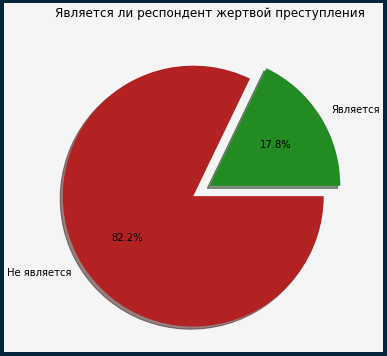

In [137]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a").set_facecolor(digclr)
plt.pie(resp_is_victim_count.tolist(), labels=resp_is_victim_count.index,
        colors=('forestgreen', 'firebrick'), explode=(0, 0.15),
        shadow=True, autopct='%1.1f%%')

plt.title("Является ли респондент жертвой преступления")
plt.show()

**Вывод:**
> Почти каждый четвертый опрошенный является жертвой преступления

***Для последующего анализа разделим данные на две выборки:***

*   Лица, являющиеся жертвами преступлений – ***victims***
*   Лица, не являющиеся жертвами преступлений – ***not_victims***



In [138]:
victims = df[df['resp_is_crime_victim'] == 1]

not_victims = df[df['resp_is_crime_victim'] == 0]

Параметры выборки лиц, являющихся жертвами преступлений

In [139]:
victims.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3001 entries, 0 to 16817
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   resp_is_crime_victim           3001 non-null   int64  
 1   resp_is_male                   3001 non-null   int64  
 2   resp_age                       3001 non-null   int64  
 3   resp_income                    2910 non-null   float64
 4   resp_edu                       3001 non-null   float64
 5   resp_ses                       3001 non-null   float64
 6   crime_is_violent_damage        3001 non-null   float64
 7   crime_is_seeking_medical_help  3001 non-null   float64
 8   crime_type                     3001 non-null   float64
 9   crime_is_daytime               3001 non-null   float64
 10  victim_damage_rub              3001 non-null   float64
 11  victim_police_reaction_time    444 non-null    float64
 12  victim_is_offender_found       3001 non-null   

Параметры выборки лиц, не являющихся жертвами преступлений

In [140]:
not_victims.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13817 entries, 100 to 16816
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   resp_is_crime_victim           13817 non-null  int64  
 1   resp_is_male                   13817 non-null  int64  
 2   resp_age                       13817 non-null  int64  
 3   resp_income                    3409 non-null   float64
 4   resp_edu                       3527 non-null   float64
 5   resp_ses                       3719 non-null   float64
 6   crime_is_violent_damage        0 non-null      float64
 7   crime_is_seeking_medical_help  0 non-null      float64
 8   crime_type                     0 non-null      float64
 9   crime_is_daytime               0 non-null      float64
 10  victim_damage_rub              13817 non-null  float64
 11  victim_police_reaction_time    0 non-null      float64
 12  victim_is_offender_found       0 non-null   

Мы можем заметить, что в выборке лиц, не являющихся жертвами преступлений присутвуют столбцы, содержащие только пустые значения, а также столбец "***victim_damage_rub***", который будет содержать только нули, удалим данные столбцы

In [141]:
not_victims = not_victims.drop(['crime_is_violent_damage', 'crime_is_seeking_medical_help',
       'crime_type', 'crime_is_daytime', 'victim_damage_rub',
       'victim_police_reaction_time', 'victim_is_offender_found',
       'offender_is_male', 'offender_is_on_duty'], axis=1)

not_victims.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13817 entries, 100 to 16816
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   resp_is_crime_victim  13817 non-null  int64  
 1   resp_is_male          13817 non-null  int64  
 2   resp_age              13817 non-null  int64  
 3   resp_income           3409 non-null   float64
 4   resp_edu              3527 non-null   float64
 5   resp_ses              3719 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 755.6 KB


***Вид данных после разбиения на две выборки:***

Вид выборки лиц, являющихся жертвами преступлений

In [142]:
victims.head(5)

,resp_is_crime_victim,resp_is_male,resp_age,resp_income,resp_edu,resp_ses,crime_is_violent_damage,crime_is_seeking_medical_help,crime_type,crime_is_daytime,victim_damage_rub,victim_police_reaction_time,victim_is_offender_found,offender_is_male,offender_is_on_duty
0,1,0,57,3.0,3.0,2.0,0.0,0.0,6.0,1.0,300.0,NaN,0.0,NaN,NaN
1,1,0,59,NaN,3.0,2.0,0.0,0.0,3.0,1.0,80000.0,1.0,1.0,1.0,NaN
2,1,0,35,NaN,3.0,1.0,0.0,0.0,6.0,1.0,3000.0,NaN,1.0,NaN,NaN
3,1,0,22,3.0,3.0,3.0,0.0,0.0,5.0,1.0,7000.0,1.0,0.0,NaN,NaN
4,1,0,79,1.0,3.0,2.0,0.0,0.0,8.0,1.0,0.0,2.0,0.0,1.0,NaN


Вид выборки лиц, не являющихся жертвами преступлений

In [143]:
not_victims.head(5)

,resp_is_crime_victim,resp_is_male,resp_age,resp_income,resp_edu,resp_ses
100,0,1,32,NaN,NaN,NaN
102,0,1,38,NaN,NaN,NaN
103,0,0,30,3.0,3.0,5.0
104,0,0,56,NaN,NaN,NaN
105,0,1,19,5.0,1.0,1.0


# Анализ выборки лиц, являющихся жертвами преступлений

## Анализ влияния полового признака на совершение преступлений и подверженность им

Определим влияние полового признака на участие в криминальной сфере. Для этого найдем процентное отношение мужчин и женщин среди пострадавших и нападавших.

Создадим функцию для замены номера категории на её название

In [144]:
def ifmale(x):
  if x:
    return "Мужчина"
  else:
    return "Женщина"

Создадим необходимые выборки из датафрейма и определим, достаточны ли их размеры для последующего анализа

In [145]:
ifmale_offender = victims['offender_is_male'].dropna().apply(ifmale)
ifmale_resp = victims['resp_is_male'].dropna().apply(ifmale)

print("Выборка содержит", len(ifmale_offender), "строк")
print("Выборка содержит", len(ifmale_resp), "строк")

Выборка содержит 1467 строк
Выборка содержит 3001 строк


Посчитаем процентное содержание каждой категории в выборках

In [146]:
offender_count = ifmale_offender.value_counts(1)

print("Среди правонарушителей:")
for i in range(len(offender_count)):
  print("{} - {:.3f}%".format(offender_count.index[i],
                              offender_count[i] * 100))

victim_count = ifmale_resp.value_counts(1)

print("\nСреди пострадавших:")
for i in range(len(offender_count)):
  print("{} - {:.3f}%".format(victim_count.index[i],
                              victim_count[i] * 100))

Среди правонарушителей:
Мужчина - 78.391%
Женщина - 21.609%

Среди пострадавших:
Женщина - 53.915%
Мужчина - 46.085%


Затем построим по получившимся значениям график.

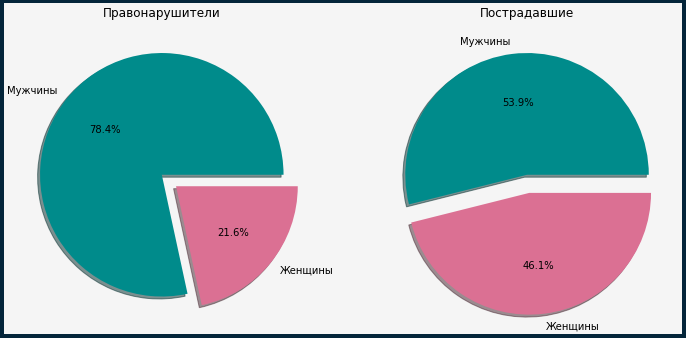

In [147]:
plt.figure(figsize=(12, 8), linewidth=8, edgecolor="#04253a") \
.set_facecolor(digclr)

ax = plt.subplot(1, 2, 1)
ax.set_title("Правонарушители")
ax.grid(which='major', color = 'gray', axis='y', linestyle=':')
ax.pie(offender_count,
       labels=["Мужчины", "Женщины"],
       colors=('darkcyan', 'palevioletred'),
       explode=(0, 0.15),
        shadow=True, autopct='%1.1f%%')

ax = plt.subplot(1, 2, 2)
ax.set_title("Пострадавшие")
ax.grid(which='major', color = 'gray', axis='y', linestyle=':')

ax.pie(victim_count,  labels=["Мужчины", "Женщины"],
       colors=('darkcyan', 'palevioletred'),
      explode=(0, 0.15),
        shadow=True, autopct='%1.1f%%')

plt.show()

**Вывод:**
> Исходя из случаев, где пол правонарушителя был установлен, мужчины чаще замешаны в преступлениях (в качестве жертвы или правонарушителя).

> Исходя из тех случаев, где пол правонарушителя был установлен, женщины являются преступником лишь в четверти случаев правонарушения.

> Среди пострадавших процент мужчин и женщин отличается незначительно.



## Был ли найден нападавший?

Определим процентное отношение случаев, в которых был найден нападавший.

Создадим функцию для замены номера категории на её название

In [148]:
def off_found_group(x):
  if x == 1.0: return "Нарушитель найден"
  else: return "Нарушитель не найден"

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [149]:
offender_found = victims['victim_is_offender_found'].dropna() \
.apply(off_found_group)

print("Выборка содержит", len(offender_found), "строк")

Выборка содержит 3001 строк


In [150]:
offender_found_count = victims['victim_is_offender_found'].dropna() \
.apply(off_found_group).value_counts(1)

print("Был ли найден преступник?")
for i in range(len(offender_found_count)):
  print("{:<20} - {:.3f}%".format(offender_found_count.index[i],
                              offender_found_count[i] * 100))

Был ли найден преступник?
Нарушитель не найден - 73.775%
Нарушитель найден    - 26.225%


Построим по полученным значениям график.

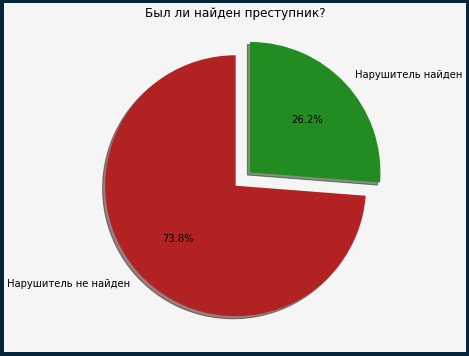

In [151]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(digclr)

plt.pie(offender_found_count.tolist(), labels=offender_found_count.index,
        colors=('firebrick', 'forestgreen'), explode=(0, 0.15),
        shadow=True, startangle=90, autopct='%1.1f%%')

plt.title('Был ли найден преступник?')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> По данным опроса, в трёх из четырёх случаев преступления правонарушитель остаётся ненайденным.

## Была ли необходима медицинская помощь?

Определим процентное отношение пострадавших от физического насилия, которым впоследствии была необходима медицинская помощь.

Создадим функцию для замены номера категории на её название

In [152]:
def is_seeking_medical_help(x):
   if x == 1.0:
     return 'Нуждался в помощи'
   else:
     return 'Не нуждался в помощи'

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [153]:
med_help = victims['crime_is_seeking_medical_help'] \
                [victims['crime_is_violent_damage'] == 1.0] \
              .apply(is_seeking_medical_help)

print("Выборка содержит", len(med_help), "строк")

Выборка содержит 350 строк


Посчитаем процентное содержание каждой категории в выборке

In [154]:
med_help_perc = med_help.value_counts(1).sort_values()

print("Была ли необходима мед. помощь?:")
for i in range(len(med_help_perc)):
  print("{:<20} - {:.3f}%".format(med_help_perc.index[i],
                                  med_help_perc[i] * 100))

Была ли необходима мед. помощь?:
Нуждался в помощи    - 48.286%
Не нуждался в помощи - 51.714%


Построим по полученным значениям график.

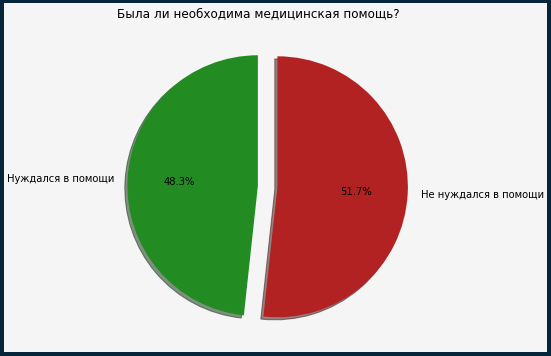

In [155]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(digclr)

plt.pie(med_help_perc, labels=med_help_perc.index,
        colors=('forestgreen', 'firebrick'), explode=(0, 0.15),
        shadow=True, startangle=90, autopct='%1.1f%%')

plt.title('Была ли необходима медицинская помощь?')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> Почти в половине случаев физического насилия пострадавший от преступления нуждался в медицинской помощи.

## Был ли нападавший при исполнении?

Определим случаи, в которых нападавших был при исполнении. Также определим вид занятости, если преступник был при исполнении.

Создадим функцию для замены номера категории на её название

In [156]:
def offender_group(x):
  d = {1.0: 'Правоприменитель',
       2.0: 'Представитель власти', 
       3.0: 'Военный', 
       4.0: 'Сотрудник коммерческой организации', 
       5.0: 'Не при исполнении'}
  return d[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [157]:
offender_on_duty = victims['offender_is_on_duty'] \
[victims['offender_is_on_duty'] != 6.0].dropna().apply(offender_group)

print("Выборка содержит", len(offender_on_duty), "строк")

Выборка содержит 1215 строк


Посчитаем процентное отношение категорий в выборке

In [158]:
offender_on_duty_group = offender_on_duty.value_counts(1).sort_values()
print("Был ли преступник при исполнении?:")
for i in range(len(offender_on_duty_group)):
  print("{:<35} - {:.3f}%".format(offender_on_duty_group.index[i],
                                  offender_on_duty_group[i] * 100))
  

Был ли преступник при исполнении?:
Военный                             - 0.658%
Представитель власти                - 2.551%
Правоприменитель                    - 3.951%
Сотрудник коммерческой организации  - 15.391%
Не при исполнении                   - 77.449%


Создадим две переменные, в первую поместим процентное соотношение видов занятости среди нападавших при исполнении, во вторую процентное соотношение нападавших при исполнении к нападавшим не при исполнении.

In [159]:
sum_type_duty = offender_on_duty[offender_on_duty != "Не при исполнении"]\
                                            .value_counts(1).sort_values()

sum_on_duty = [sum(offender_on_duty_group[:4]), offender_on_duty_group[4]]

print("Был ли преступник при исполнении?:")
print("При исполнении    - {:.3f}%\nНе при исполнении - {:.3f}%\n" \
      .format(sum_on_duty[0] * 100, sum_on_duty[1] * 100))

print("Соотношение видов занятости среди нападавших при исполнении:")
for i in range(len(sum_type_duty)):
  print("{:<35} - {:.3f}%".format(sum_type_duty.index[i],
                                  sum_type_duty[i] * 100))

Был ли преступник при исполнении?:
При исполнении    - 22.551%
Не при исполнении - 77.449%

Соотношение видов занятости среди нападавших при исполнении:
Военный                             - 2.920%
Представитель власти                - 11.314%
Правоприменитель                    - 17.518%
Сотрудник коммерческой организации  - 68.248%


Построим по полученным значениям график.

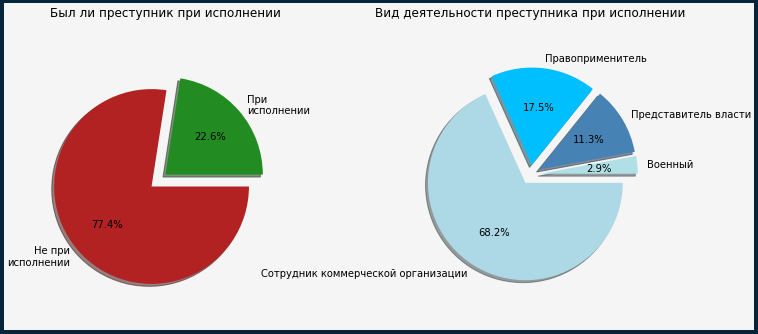

In [160]:
# Красивые графики
plt.figure(figsize=(12, 8), linewidth=8, edgecolor="#04253a") \
.set_facecolor(digclr)

ax = plt.subplot(1, 2, 1)
ax.set_title("Был ли преступник при исполнении")
ax.grid(which='major', color = 'gray', axis='y', linestyle=':')

ax.pie(sum_on_duty,
       labels=["При\nисполнении", "Не при\nисполнении"], radius=0.8,
       colors=('forestgreen', 'firebrick'), explode=(0, 0.15),
        shadow=True, autopct='%1.1f%%')

ax = plt.subplot(1, 2, 2)
ax.set_title("Вид деятельности преступника при исполнении")
ax.grid(which='major', color = 'gray', axis='y', linestyle=':')

ax.pie(sum_type_duty, labels=sum_type_duty.index,
       radius=0.8, colors=colors,
       explode=(0.08, 0.08, 0.08, 0.08),
       shadow=True, autopct='%1.1f%%')

plt.show()

**Вывод:**
> Более 20% злоумышленников находились при исполнении своих обязанностей

> Большая часть правонарушителей, находящихся при исполнении обязанностей, относится к категории сотрудников коммерческих организаций

> Более 30% правонарушителей являются чиновниками (госслужащими), среди них большую часть преступлений совершают правоприменители (17.5%), меньшую – военные (2.9%), а представители власти, по данным опроса, занимают 11.3% от всех правонарушителей при исполнении.

## Анализ частоты видов преступлений

Определим процентное отношение частоты каждого преступления.

Создадим функцию для замены номера категории на её название

In [161]:
def crime_type_rename(x):
  dic = {1.0: 'Нападение', 
         2.0: 'Угрозы ', 
         3.0: 'Грабеж и разбой ', 
         4.0: 'Кража', 
         5.0: 'Мошенничество', 
         6.0: 'Мошенничество', 
         7.0: 'Прочее'}
  return dic[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [162]:
crime_type = victims['crime_type'].drop(
    victims['crime_type'][victims['crime_type'] == 8.0].index) \
    .apply(crime_type_rename)

print("Выборка содержит", len(crime_type), "строк")

Выборка содержит 2422 строк


Посчитаем процентное отношение каждой категории в выборке

In [163]:
crime_type_perc = crime_type.value_counts(1)

print("Вид преступления:")
for i in range(len(crime_type_perc)):
  print("{:<16} - {:.3f}%".format(crime_type_perc.index[i],
                                  crime_type_perc[i] * 100))


Вид преступления:
Мошенничество    - 40.173%
Кража            - 25.021%
Грабеж и разбой  - 12.428%
Угрозы           - 8.629%
Нападение        - 8.051%
Прочее           - 5.698%


Построим по полученным значениям график

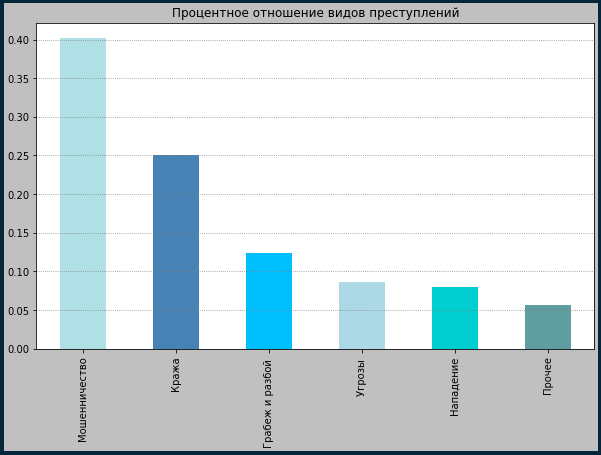

In [164]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

crime_type_perc.plot.bar(color=colors)
plt.title('Процентное отношение видов преступлений')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> Наиболее частый вид преступления по данным опроса – мошенничество (почти половина от всех преступлений)

> Кражи (тайные хищения) в 2 раза распространеннее грабежей и разбоев (насильственных хищений)

> Количество угроз незначительно больше количества нападений

> Прочие правонарушения занимают чуть более 5% от всех преступлений

> Таким образом, по данным опроса, мы можем сделать вывод, что преступления, подразумевающие использование физической силы, совершаются реже, чем преступления без насилия.

## Анализ влияния возраста на подверженность преступлениям

Определим зависимость возраста человека и подверженности преступлению. 

Создадим функцию для замены номера категории на её название

In [165]:
def age_group(x):
  if 18 <= x <= 24:
    return '18-24'
  elif 25 <= x <= 34:
    return '25-34'
  elif 35 <= x <= 44:
    return '35-44'
  elif 45 <= x <= 54:
    return '45-54'
  elif 55 <= x <= 64:
    return '55-64'
  elif x >= 65:
    return '65+'

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [166]:
resp_age = victims['resp_age'].apply(age_group)

print("Выборка содержит", len(resp_age), "строк")

Выборка содержит 3001 строк


Посчитаем процентное содержание каждой категории в выборке

In [167]:
group_resp_age = resp_age.value_counts(1).sort_index()

print("Среди пострадавших:")
for i in range(len(group_resp_age)):
  print("{:^5} лет - {:.3f}%".format(group_resp_age.index[i],
                                  group_resp_age[i] * 100))

Среди пострадавших:
18-24 лет - 11.096%
25-34 лет - 28.391%
35-44 лет - 21.593%
45-54 лет - 15.095%
55-64 лет - 13.462%
 65+  лет - 10.363%


Построим по полученным значениям график.

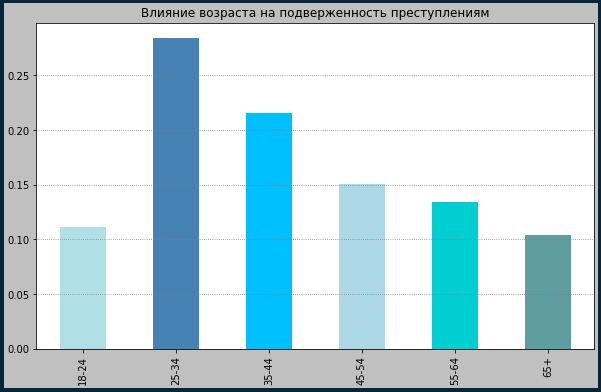

In [168]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)
group_resp_age.plot.bar(color=colors)

plt.title('Влияние возраста на подверженность преступлениям')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> Наименее подвержены преступлениям возрастные категории "18-24" и "65+".

> Наиболее подвержены преступлениям лица 25-34 лет, далее процент жертв убывает экспоненциально.


Попробуем найти зависимость типа преступления от возраста. Для этого создадим выборки по каждой возрастной категории и посчитаем процент каждого вида преступлений среди полученных выборок

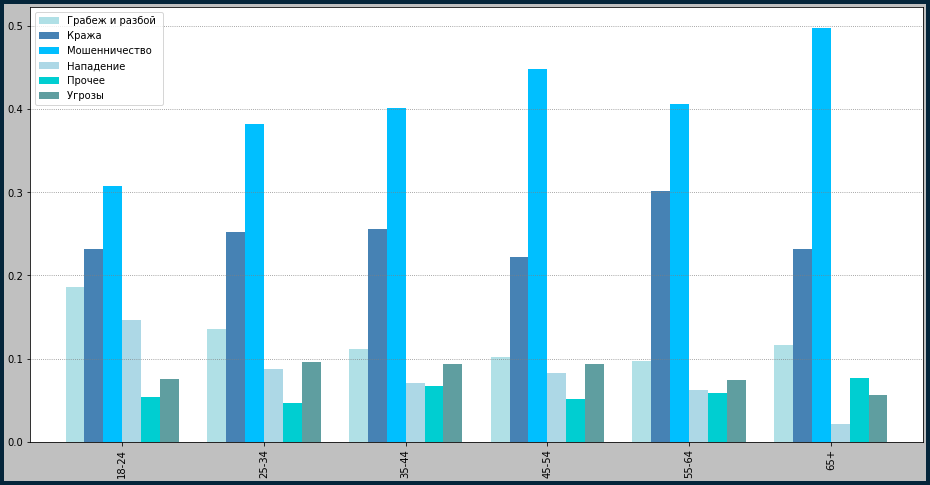

In [169]:
victims['resp_age_group'] = victims['resp_age'].apply(age_group)

crime_age = pd.concat([victims['crime_type'].drop(victims['crime_type']
                        [victims['crime_type'] == 8.0].index),
                        victims['resp_age_group']], axis=1).dropna()

age_lst = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

s = []
for i in age_lst:
  s.append(crime_age['crime_type'][crime_age['resp_age_group'] == i] \
     .apply(crime_type_rename).value_counts(1).sort_index())

fp = pd.DataFrame(s,
              index=age_lst,
              columns=s[0].index)

fig, ax = plt.subplots(linewidth=8, edgecolor="#04253a")

ax.set_facecolor('white')
fig.set_figwidth(16)    #  ширина Figure
fig.set_figheight(8)    #  высота Figure
fig.set_facecolor(pltclr)

fp.plot.bar(color=colors, ax=ax, width=0.8)

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

plt.show()


**Вывод:**


> Пожилые люди чаще других становятся жертвами мошенничества, в то время как молодые – реже всего. Вероятно, это связанно с совершенствованием и цифровизацией методов мошенничества, что подвергает лиц, не обладающих достаточной цифровой грамотностью, наибольшим рискам со стороны мошенников.

> Молодые люди чаще остальных становятся жертвами грабежей и разбоев, далее процент плавно уменьшается и слегка возрастает у лиц возраста "65+".

> Наиболее подвержены кражам лица категории "55-64", остальные категории по процентному отношению отличаются незначительно.

> Наименее подвержены угрозам возрастные группы "18-24" и "65+", остальные категории по процентному отношению отличаются незначительно.

> Жертвами краж чаще всего становятся люди возрастной категории "55-64". Возможно, это связанно с тем, что люди к данному периоду жизни успевают уже материально обеспеченны и имеют накопления к выходу на пенсию, чем вызывают интерес преступников.

> Прочим преступлениям больше всего подвержены пенсионеры.





## Анализ влияния дохода на подверженность преступлениям

Для начала найдем процентное отношение каждого вида дохода среди пострадавших.

Создадим функцию для замены номера категории на её название

In [170]:
def income(x):
  d = {1.0: "Бедность",
       2.0: "Низкий",
       3.0: "Средний",
       4.0: "Высокий",
       5.0: "Очень высокий"}
  return d[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [171]:
resp_income = victims['resp_income'].dropna() \
                    .sort_values().apply(income)

print("Выборка содержит", len(resp_income), "строк")

Выборка содержит 2910 строк


Посчитаем процентное содержание каждой категории в выборке

In [172]:
group_resp_income = resp_income.value_counts(1). \
                    reindex(resp_income.unique())

print("Среди пострадавших:")
for i in range(len(group_resp_income)):
  print("{:<13} - {:.3f}%".format(group_resp_income.index[i],
                                  group_resp_income[i] * 100))


Среди пострадавших:
Бедность      - 10.103%
Низкий        - 27.491%
Средний       - 35.739%
Высокий       - 18.969%
Очень высокий - 7.698%


Построим по полученным значениям график.

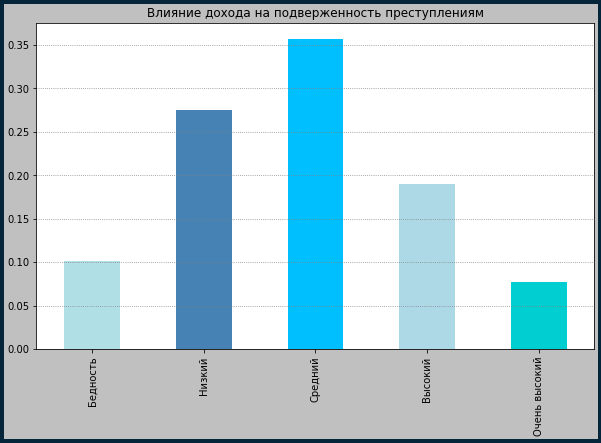

In [173]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

group_resp_income.plot.bar(color=colors)

plt.title('Влияние дохода на подверженность преступлениям')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод**:


> Распределение процентного отношения подверженности преступлениям среди разных уровней дохода близко к нормальному.

> Логично предположить, что бедные менее подвержены преступлениям из-за отсутствия материальных средств и имущества, а люди с очень высоким уровнем дохода – в силу того, что их уровень достатка позволяет позаботиться о безопасности своих ценностей.


Определим зависимость между уровнем дохода и типом преступления. Для этого создадим выборки по каждому уровню дохода и найдем процентное соотношение видов преступлений среди полученных выборок

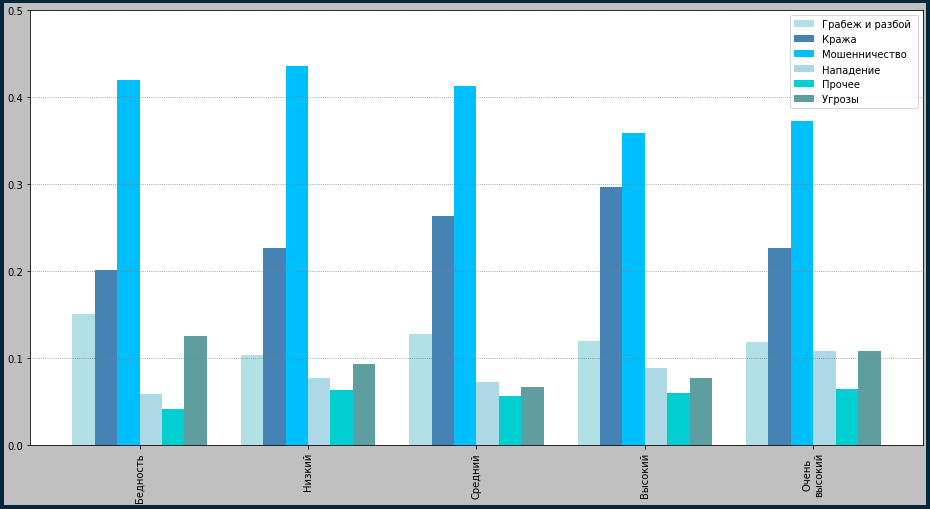

In [174]:
#Графики процента вида преступления для каждого уровня доходов

crime_income = pd.concat([victims['crime_type'].drop(victims['crime_type']
                        [victims['crime_type'] == 8.0].index),
                        victims['resp_income']], axis=1).dropna()

s = []
for i in range(1, 6):
  s.append(crime_income[crime_income['resp_income'] == i]['crime_type']
           .apply(crime_type_rename).value_counts(1).sort_index())
  
crime_type_lst = ["Бедность", "Низкий", "Средний", "Высокий", "Очень\nвысокий"]

fp = pd.DataFrame(s,
              index=crime_type_lst,
              columns=s[0].index)

fig, ax = plt.subplots(linewidth=8, edgecolor="#04253a")

ax.set_facecolor('white')
fig.set_figwidth(16)    #  ширина Figure
fig.set_figheight(8)    #  высота Figure
fig.set_facecolor(pltclr)

fp.plot.bar(color=colors, ax=ax, width=0.8)

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

plt.ylim(top=0.5)

plt.show()

**Вывод:**

> Среди всех уровней дохода наиболее распространённым видом преступления является мошенничество. Наиболее подвержены люди с низкими и очень низкими доходами.

> Бедные больше других подвержены грабежам и разбоям, угрозам, но меньше всех – нападениям и прочим видам преступлений.

> Люди с очень высоким уровнем дохода часто становятся жертвами угроз, нападений, грабежей и разбоев, что связанно с повышенной заинтересованностью преступников в заполучении чужих материальных ценностей.

> Высокий класс больше других подвержен кражам.



## Анализ влияния образования на подверженность преступлениям


Для начала найдем процентное отношение каждого вида образования среди пострадавших.

Создадим функцию для замены номера категории на её название

In [175]:
def resp_edu_group(x):
  d = {1: "Полное среднее и ниже",
       2: "Среднее спец-ное/техническое\nили нач-ное профес-ное",
       3: "Высшее и незаконченное высшее"}
  return d[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [176]:
resp_edu = victims["resp_edu"].dropna().sort_values() \
                              .apply(resp_edu_group)

print("Выборка содержит", len(resp_edu), "строк")

Выборка содержит 3001 строк


Посчитаем процентное содержание каждой категории в выборке

In [177]:
group_resp_edu = resp_edu.value_counts(1). \
                    reindex(resp_edu.unique())

print("Среди пострадавших:")
for i in range(len(group_resp_edu)):
  print("{:<13} - {:.3f}%".format(group_resp_edu.index[i],
                                  group_resp_edu[i] * 100))

Среди пострадавших:
Полное среднее и ниже - 18.094%
Среднее спец-ное/техническое
или нач-ное профес-ное - 35.322%
Высшее и незаконченное высшее - 46.584%


Построим по полученным значениям график.

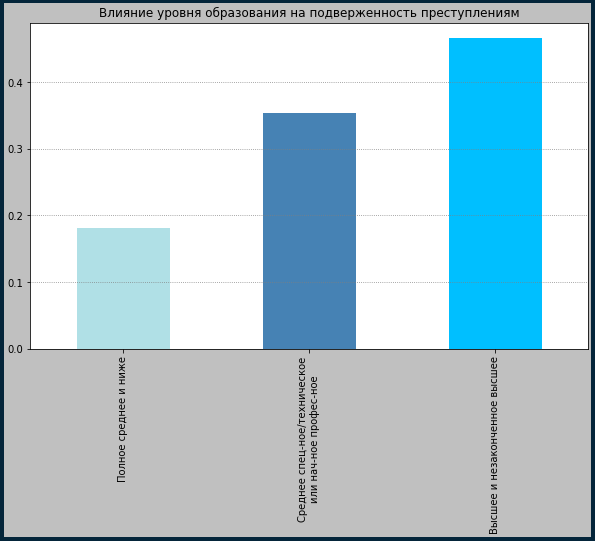

In [178]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

group_resp_edu.plot.bar(color=colors)

plt.title('Влияние уровня образования на подверженность преступлениям')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**

> Почти половина пострадавших респондентов имеет высшее или незаконченное высшее образование

> Чуть больше трети пострадавших респондентов имеет среднее специальное/техническое или начальное профессиональное образование

> Менее четверти пострадавших респондентов имеет полное среднее образование и ниже

*Данное распределение объясняется тем, что люди категории 18-24 имеют более низкий уровень образования и менее подвержены преступлениям, чем люди более старших возрастов, которые соответственно имеют более высокий уровень образования*

Определим зависимость между образованием и типом преступления. Для этого создадим выборки по каждому виду образования и найдем процентное соотношение видов преступлений среди полученных выборок

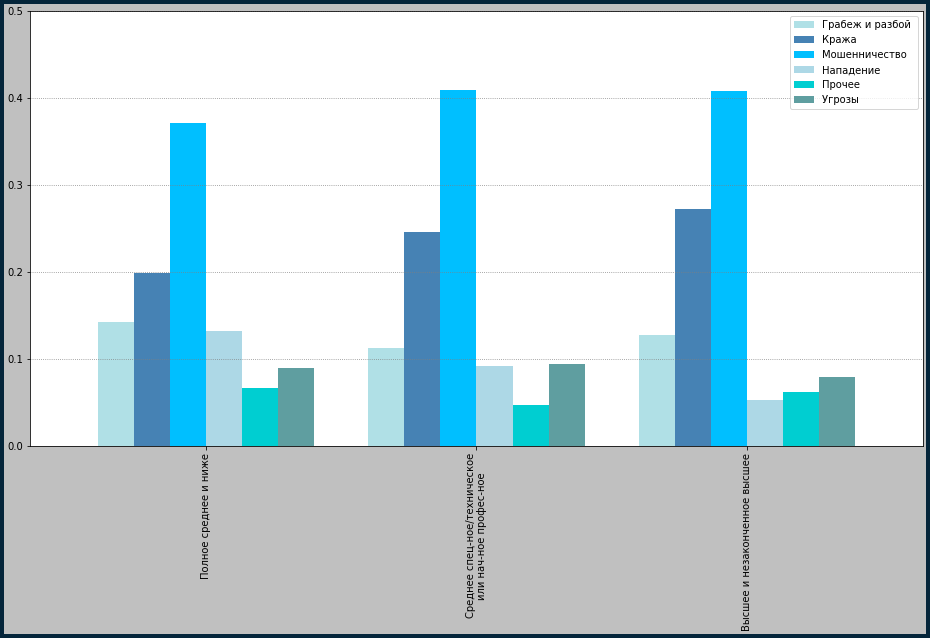

In [179]:
crime_edu = pd.concat([victims['crime_type'].drop(victims['crime_type']
                        [victims['crime_type'] == 8.0].index),
                        victims['resp_edu']], axis=1).dropna()

s = []
for i in range(1, 4):
  s.append(crime_edu[crime_edu['resp_edu'] == i]['crime_type']
           .apply(crime_type_rename).value_counts(1).sort_index())
  
edu_lst = ["Полное среднее и ниже",
           "Среднее спец-ное/техническое\nили нач-ное профес-ное",
           "Высшее и незаконченное высшее"]

fp = pd.DataFrame(s,
              index=edu_lst,
              columns=s[0].index)

fig, ax = plt.subplots(linewidth=8, edgecolor="#04253a")

ax.set_facecolor('white')
fig.set_figwidth(16)    #  ширина Figure
fig.set_figheight(8)    #  высота Figure
fig.set_facecolor(pltclr)

fp.plot.bar(color=colors, ax=ax, width=0.8)

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

plt.ylim(top=0.5)

plt.show()

**Вывод:**

> По мере роста уровня образования респондентов растет уровень краж, что, возможно, связано с тем, что более высокообразованные люди имеют более высокооплачиваемую работу и, следовательно, обладают материальными благами, что делает их более вероятными жертвами покушений на кражи.

> По мере роста уровня образования респондентов падает количество совершаемых в их сторону нападений.

> Уровни остальных преступлений не имеют прямых зависимостей от уровня образования опрошенного.


## Анализ влияния социально–экономического статуса на подверженность преступлениям

Создадим функцию для замены номера категории на её название

In [180]:
def resp_ses_rename(x):
    d = {1.0: "Безработный",
         2.0: "Пенсионер",
         3.0: "Студент",
         4.0: "Рабочий",
         5.0: "Служащий",
         6.0: "Руководитель"}
    return d[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [181]:
resp_ses = victims["resp_ses"].dropna().sort_values().apply(resp_ses_rename)

print("Выборка содержит", len(resp_ses), "строк")

Выборка содержит 3001 строк


Посчитаем процентное содержание каждой категории в выборке

In [182]:
group_resp_ses = resp_ses.value_counts(1).sort_values()

print("Среди пострадавших:")
for i in range(len(group_resp_ses)):
  print("{:<13} - {:.3f}%".format(group_resp_ses.index[i],
                                  group_resp_ses[i] * 100))

Среди пострадавших:
Студент       - 9.597%
Служащий      - 16.961%
Безработный   - 17.094%
Руководитель  - 17.394%
Рабочий       - 18.494%
Пенсионер     - 20.460%


Построим по полученным значениям график.


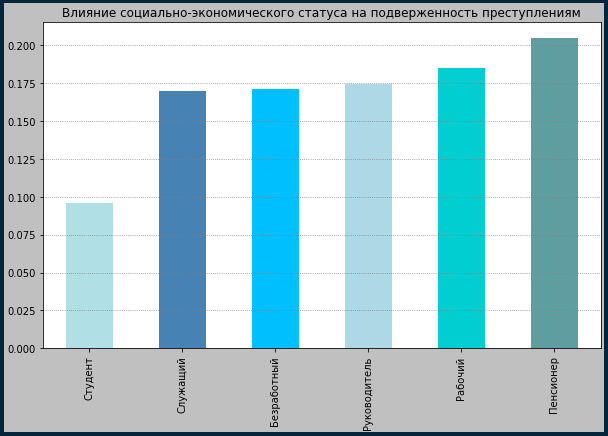

In [183]:
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

group_resp_ses.plot.bar(color=colors)

plt.title('Влияние социально-экономического статуса на подверженность преступлениям')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**

> Студенты меньше всего подвергаются преступлениям.

> Служащие, безработные, руководители и рабочие примерно в равной степени подвержены преступлениям.

> Пенсионеры наиболее подвержены преступлениям. Это связано с тем, что пенсионеры из-за своего возраста зачастую становятся легкой добычей для мошенников и воров.

Определим зависимость между социально-экономическим статусом и типом преступления. Для этого создадим выборки по каждому социально-экономическому статусу и найдем процентное соотношение видов преступлений среди полученных выборок

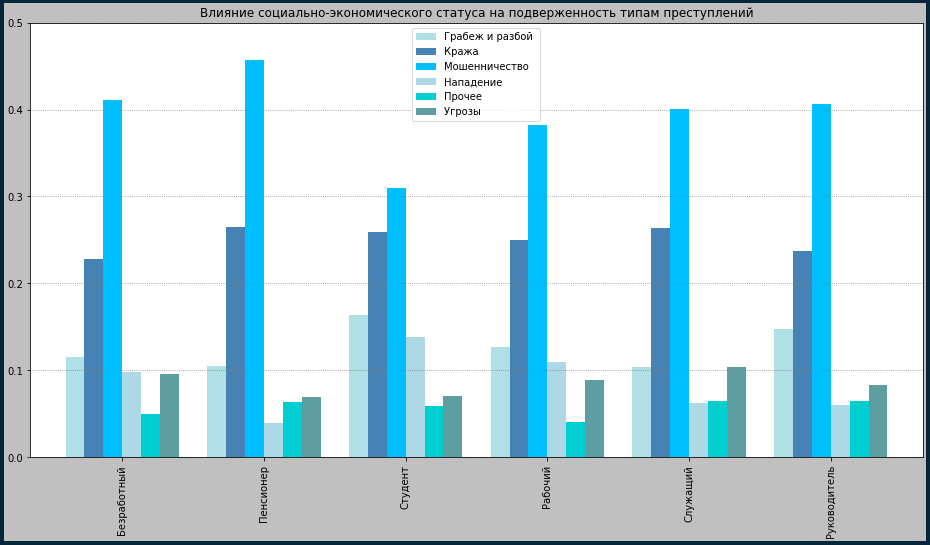

In [184]:
crime_ses = pd.concat([victims['crime_type'].drop(victims['crime_type']
                        [victims['crime_type'] == 8.0].index),
                        victims['resp_ses']], axis=1).dropna()

s = []
for i in range(1, 7):
  s.append(crime_ses[crime_ses['resp_ses'] == i]['crime_type']
           .apply(crime_type_rename).value_counts(1).sort_index())
  
ses_lst = ["Безработный", "Пенсионер", "Студент",
           "Рабочий", "Служащий", "Руководитель"]

fp = pd.DataFrame(s,
              index=ses_lst,
              columns=s[0].index)

fig, ax = plt.subplots(linewidth=8, edgecolor="#04253a")

ax.set_facecolor('white')
fig.set_figwidth(16)    #  ширина Figure
fig.set_figheight(8)    #  высота Figure
fig.set_facecolor(pltclr)

fp.plot.bar(color=colors, ax=ax, width=0.8)

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

plt.ylim(top=0.5)

plt.title('Влияние социально-экономического статуса на подверженность типам преступлений')

plt.show()

**Вывод:**

> Пенсионеры чаще всего становятся жертвами мошенников и прочих преступлений, неуказанных в списке, что подтверждает вывод из анализа влияния возраста на подверженность преступлениям категории "65+", в которую входят большинство пенсионеров.

> Студенты больше других подвергаются грабежам, разбоям и нападениям, меньше других – мошенничеству, что тоже подтверждает вывод из анализа влияния возраста на подверженность преступлениям категории "18-24", к которой можно причислить большинство студентов.

> Угрозам чаще всего подвергаются служащие и безработные.

> Кражам немногим чаще подвержены пенсионеры и служащие.

> Пенсионеры реже других подвергаются нападениям и грабежам.

> Прочим преступлениям меньше всего подвергаются рабочие.

## Анализ скорости реагирования правоохранителей



Создадим функцию для замены номера категории на её название

In [185]:
def reaction_time_group(x):
  d = {1.0: "Менее чем 30 минут",
       2.0: "Менее чем 1 час",
       3.0: "Менее чем 3 часа",
       4.0: "Менее чем 6 часов",
       5.0: "Менее чем 12 часов",
       6.0: "Не приехали"}
  return d[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [186]:
police_react = victims['victim_police_reaction_time'] \
              .dropna().sort_values().drop(
              victims['victim_police_reaction_time']
              [victims['victim_police_reaction_time'] == 7.0].index) \
              .apply(reaction_time_group)

print("Выборка содержит", len(police_react), "строк")

Выборка содержит 422 строк


Посчитаем процентное содержание каждой категории в выборке

In [187]:
group_police_reaction = police_react.value_counts(1) \
                        .reindex(police_react.unique())

print("Полиция среагировала:")
for i in range(len(group_police_reaction)):
  print("{:<18} - {:.3f}%".format(group_police_reaction.index[i],
                                  group_police_reaction[i] * 100))


Полиция среагировала:
Менее чем 30 минут - 50.000%
Менее чем 1 час    - 25.592%
Менее чем 3 часа   - 10.427%
Менее чем 6 часов  - 1.659%
Менее чем 12 часов - 2.844%
Не приехали        - 9.479%


Построим по полученным значениям график.


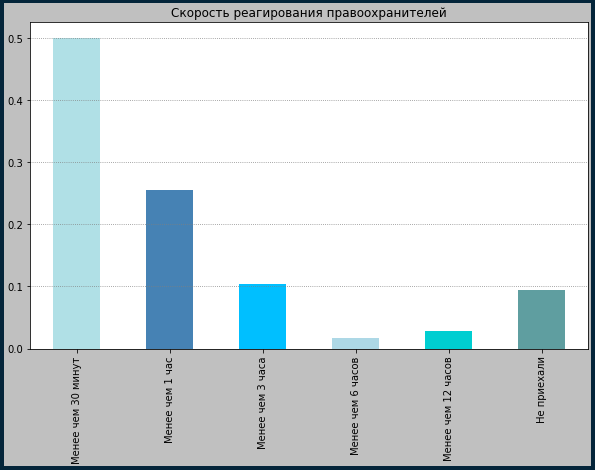

In [188]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

group_police_reaction.plot.bar(color=colors)

plt.title('Скорость реагирования правоохранителей')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> В половине случаев правоохранители реагируют на вызов с должной скоростью (меньше 30 минут)

> В четверти случаев полицейские приезжают менее, чем за час.

> В 10% случаев полицейские приезжают в течение трех часов.

> Почти в каждом десятом случае полицейские не приезжают по вызову

## Анализ материального ущерба пострадавших

Проанализируем материальный ущерб пострадавшим, определим медианное и среднее значение материального ущерба.

Создадим выборку, содержащую материальный ущерб жертв преступлений и посчитаем её размер

In [189]:
damage_rub = victims['victim_damage_rub'] \
            [victims['victim_damage_rub'] != 0].dropna() 

damage_rub.rename("damage")

0           300.0
1         80000.0
2          3000.0
3          7000.0
5          2000.0
           ...   
16778     10000.0
16788      1000.0
16803     12000.0
16807    124000.0
16814      1500.0
Name: damage, Length: 2007, dtype: float64

Теперь посчитаем средний и медианный материальные ущербы

In [190]:
damage_median = damage_rub.median()

damage_mean = damage_rub.mean()

print("Медиана материального ущерба - {} рублей"
        .format(int(damage_median)))

print("Среднее материального ущерба - {} рублей"
        .format(int(damage_mean)))

Медиана материального ущерба - 12000 рублей
Среднее материального ущерба - 3116267 рублей


Мы можем заметить, что среднее значение значительно отличается от медианного, возможно это происходит из-за выбросов в данных. Попробуем их удалить.

Для этого сначала определим вид распределения.

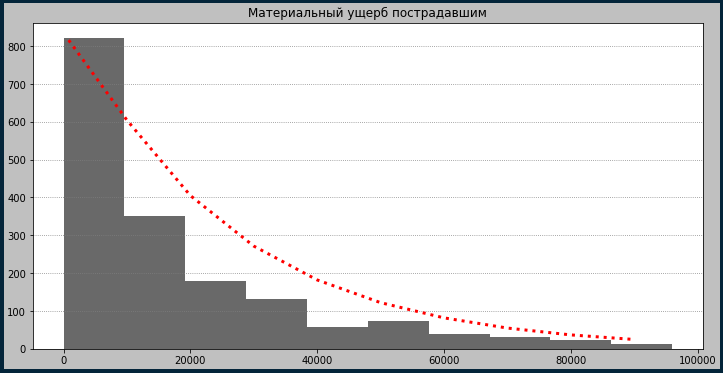

In [191]:
def exp(x):
    return 1.4 * 644 * math.e ** (-0.4 * (x / 10000))


X = [i for i in range(10000, 100000, 10000)]

Y_ideal = [exp(2500)] + [exp(i) for i in X]

plt.figure(figsize=(12, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

plt.hist(damage_rub[damage_rub < 100000], color='dimgray')
plt.plot([exp(2500)] + X, Y_ideal, color="red", linewidth=3, linestyle=':')

plt.title('Материальный ущерб пострадавшим')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':') # boxplot

Исходя из графика видно, что распределение является ненормальным, а именно на графике представлено экспоненциальное распределение.

Для определения выбросов было решено использовать межквартильный размах.

Нам нужно определить первый (Q1) и третий (Q3) квартили.

In [192]:
q25, q75 = np.percentile(damage_rub, [75, 25])

Рассчитаем расстояние между третьим и первым квартилем (IQR). Считается как разность значений, получившихся при расчете Q3 и Q1.

In [193]:
iqr = np.subtract(q25, q75)

Определяем внутренние верхнюю и нижнюю границу для выбросов

In [194]:
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

print("Нижняя граница равна", lower)
print("Верхняя граница равна", upper)

Нижняя граница равна -13250.0
Верхняя граница равна 57750.0


Теперь удалим все значения превышающие верхнюю границу. Так как значения в нашей выборке начинаются с 0, а нижняя граница значительно его меньше, мы вправе её проигнорировать

In [195]:
print("До исключения выбросов выборка содержит", len(damage_rub), "строк")

damage_rub = damage_rub[damage_rub <= upper]

print("После исключения выбросов выборка содержит", len(damage_rub), "строк")

До исключения выбросов выборка содержит 2007 строк
После исключения выбросов выборка содержит 1611 строк


Построим "ящик с усами".

<AxesSubplot:>

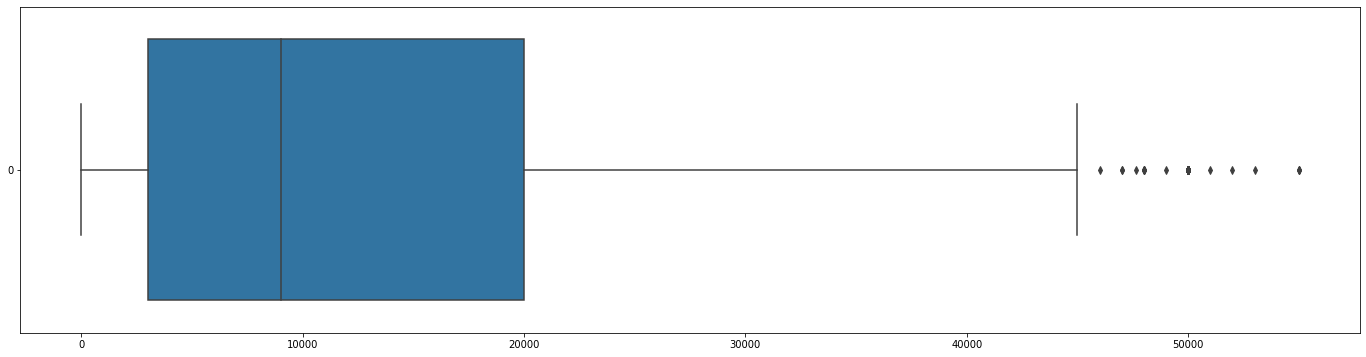

In [196]:
fig, ax = plt.subplots(figsize=(24, 6))
sns.boxplot(data=damage_rub, orient="h", ax=ax)

Как мы видим, большинство выбросов были удалены.

Повторим вычисления среднего и медианы

In [197]:
damage_median_new = damage_rub.median()

damage_mean_new = damage_rub.mean()

print("Медиана материального ущерба после исключения выбросов - {} рублей"
        .format(int(damage_median_new)))

print("Среднее материального ущерба после исключения выбросов - {} рублей"
        .format(int(damage_mean_new)))

Медиана материального ущерба после исключения выбросов - 9000 рублей
Среднее материального ущерба после исключения выбросов - 13243 рублей


**Вывод:**
> Существуют случаи, когда ущерб в результате преступления значительно превышает ущерб в большинстве других случаев. Из-за значительного влияния на среднее и медианное значение, данные случаи были исключены.

> Медианный материальный ущерб после исключения выбросов данных, полученный пострадавшими в результате преступления, составляет 7 000 рублей.

> Средний материальный ущерб после исключения выбросов данных, полученный пострадавшими в результате преступления, составляет 9 818 рублей.

## Анализ зависимости вида преступлений от времени суток

Определим процентную зависимость количества совершаемых преступлений от времени суток.

Создадим функцию для замены номера категории на её название

In [198]:
def if_day(x):
  if x == 1.0:
    return 'День'
  else:
    return 'Ночь'

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [199]:
victims_time = victims['crime_is_daytime'].dropna() \
.apply(if_day)

print("Выборка содержит", len(victims_time), "строк")

Выборка содержит 3001 строк


Посчитаем процентное содержание каждой категории в выборке

In [200]:
victims_time_count = victims_time.value_counts(1)

print("Время суток в момент совершения преступления:")
for i in range(len(victims_time_count)):
  print("{} - {:.3f}%".format(victims_time_count.index[i],
                                  victims_time_count[i] * 100))

Время суток в момент совершения преступления:
День - 65.178%
Ночь - 34.822%


Построим по полученным значениям график.

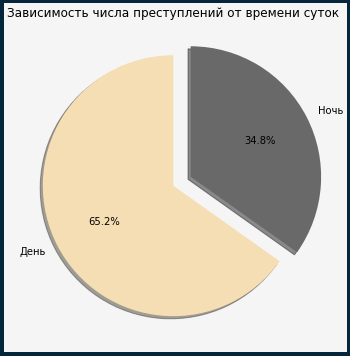

In [201]:
#Красивые графики
ax = plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a")
ax.set_facecolor(digclr)


plt.pie(victims_time_count, labels=victims_time_count.index, colors=('wheat','dimgray'),
        explode=(0, 0.15), shadow=True, startangle=90, autopct='%1.1f%%')

plt.title('Зависимость числа преступлений от времени суток')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> Большая часть преступлений совершается в дневное время суток.

Затем попробуем найти зависимость между определенным видом преступления и временем суток. Для этого создадим выборки по каждому виду преступлений и посчитаем процентное соотношение преступлений ночью и преступлений днем

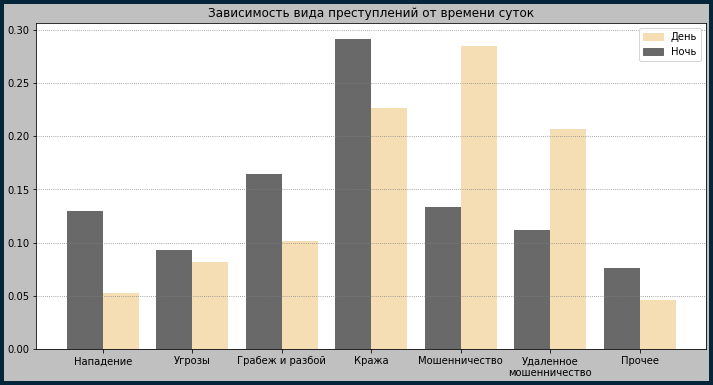

In [202]:
crimes = victims['crime_type'][victims['crime_type'] != 8.0]

daytime_crime = crimes[victims['crime_is_daytime'] == 1.0] \
.value_counts(1).sort_index().tolist()

nighttime_crime = crimes[victims['crime_is_daytime'] == 0.0] \
.value_counts(1).sort_index().tolist()

# Красивые графики
tick_names = ['Нападение',
              'Угрозы',
              'Грабеж и разбой',
              'Кража',
              'Мошенничество',
              'Удаленное\nмошенничество',
              'Прочее'] 

fig, ax = plt.subplots(linewidth=8, edgecolor="#04253a")

ax.bar(tick_names, daytime_crime, align='edge',
       width=0.4, color='wheat')
ax.bar(tick_names, nighttime_crime, align='edge',
       width=-0.4, color='dimgray')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

plt.title('Зависимость вида преступлений от времени суток')

day_patch = mpatches.Patch(color='wheat', label='День')
night_patch = mpatches.Patch(color='dimgray', label='Ночь')
ax.legend(handles=[day_patch, night_patch])

ax.set_facecolor('white')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
fig.set_facecolor(pltclr)

**Вывод:**
> Наиболее серьезные преступления, такие как нападения, угрозы, грабежи и разбои, кражи, совершаются в большинстве случаев в тёмное время суток

> Преступления, связанные с мошенничеством и удаленным мошенничеством, чаще всего совершаются днём

> Таким образом, несмотря на то, что большинство преступлений осуществляется днём, наиболее тяжкие из них осуществляются ночью. Процент дневных преступлений больше, поскольку значительная часть от них занимает мошенничество, осуществляемое в большинстве случаев в светлое время суток.

## Составим идеальный портрет человека, являющегося жертвой преступления

> **Мужчина**

> **25-34 года**

> **Средний уровень дохода**

> **Высшее или незаконченное высшее образование**

> **Социально-экономеческий статус — рабочий**

# Анализ выборки лиц, не являющихся жертвами преступлений

## Анализ полового признака

Создадим функцию для замены номера категории на её название

In [203]:
def ifmale(x):
  if x:
    return "Мужчина"
  else:
    return "Женщина"

Создадим необходимые выборки из датафрейма и определим, достаточны ли их размеры для последующего анализа

In [204]:
not_ifmale_resp = not_victims['resp_is_male'].dropna().apply(ifmale)

print("Выборка содержит", len(not_ifmale_resp), "строк")

Выборка содержит 13817 строк


Посчитаем процентное содержание каждой категории в выборках

In [205]:
not_victim_count = not_ifmale_resp.value_counts(1)

print("\nСреди пострадавших:")
for i in range(len(not_victim_count)):
  print("{} - {:.3f}%".format(not_victim_count.index[i],
                              not_victim_count[i] * 100))


Среди пострадавших:
Женщина - 55.555%
Мужчина - 44.445%


Затем построим по получившимся значениям график.

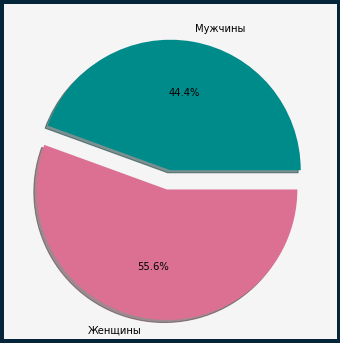

In [206]:
ax = plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a")
ax.set_facecolor(digclr)

plt.pie(not_victim_count[::-1],  labels=["Мужчины","Женщины"],
       colors=('darkcyan', 'palevioletred'),
      explode=(0, 0.15),
        shadow=True, autopct='%1.1f%%')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**

> Среди лиц, не являющихся жертвами преступлений, чуть больше женщин.

## Анализ возраста

Создадим функцию для замены номера категории на её название

In [207]:
def age_group(x):
  if 18 <= x <= 24:
    return '18-24'
  elif 25 <= x <= 34:
    return '25-34'
  elif 35 <= x <= 44:
    return '35-44'
  elif 45 <= x <= 54:
    return '45-54'
  elif 55 <= x <= 64:
    return '55-64'
  elif x >= 65:
    return '65+'

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [208]:
not_resp_age = not_victims['resp_age'].apply(age_group)

print("Выборка содержит", len(resp_age), "строк")

Выборка содержит 3001 строк


Посчитаем процентное содержание каждой категории в выборке

In [209]:
not_group_resp_age = not_resp_age.value_counts(1).sort_index()

print("Среди пострадавших:")
for i in range(len(not_group_resp_age)):
  print("{:^5} лет - {:.3f}%".format(not_group_resp_age.index[i],
                                  not_group_resp_age[i] * 100))

Среди пострадавших:
18-24 лет - 10.313%
25-34 лет - 24.224%
35-44 лет - 20.663%
45-54 лет - 16.805%
55-64 лет - 16.335%
 65+  лет - 11.660%


Построим по полученным значениям график.

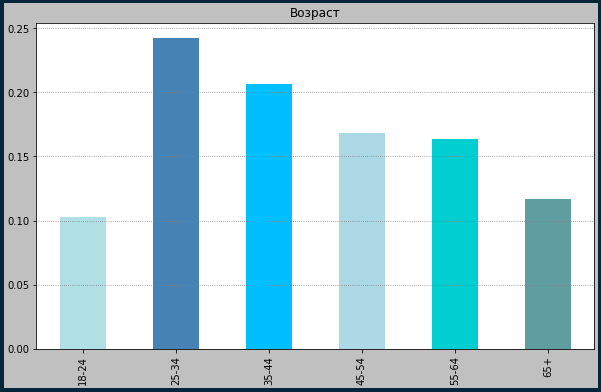

In [210]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)
not_group_resp_age.plot.bar(color=colors)

plt.title('Возраст')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**

> Меньшую часть данной выборки составляют лица категории "18-24"

> Большую часть выборки составляют лица категории "25-34", далее процент каждой группы убывает.

## Анализ уровня дохода

In [211]:
def income(x):
  d = {1.0: "Бедность",
       2.0: "Низкий",
       3.0: "Средний",
       4.0: "Высокий",
       5.0: "Очень высокий"}
  return d[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [212]:
not_resp_income = not_victims['resp_income'].dropna() \
                    .sort_values().apply(income)

print("Выборка содержит", len(not_resp_income), "строк")

Выборка содержит 3409 строк


Посчитаем процентное содержание каждой категории в выборке

In [213]:
not_group_resp_income = not_resp_income.value_counts(1). \
                    reindex(resp_income.unique())

print("Среди пострадавших:")
for i in range(len(not_group_resp_income)):
  print("{:<13} - {:.3f}%".format(not_group_resp_income.index[i],
                                  not_group_resp_income[i] * 100))


Среди пострадавших:
Бедность      - 8.859%
Низкий        - 28.806%
Средний       - 36.228%
Высокий       - 18.158%
Очень высокий - 7.950%


Построим по полученным значениям график.

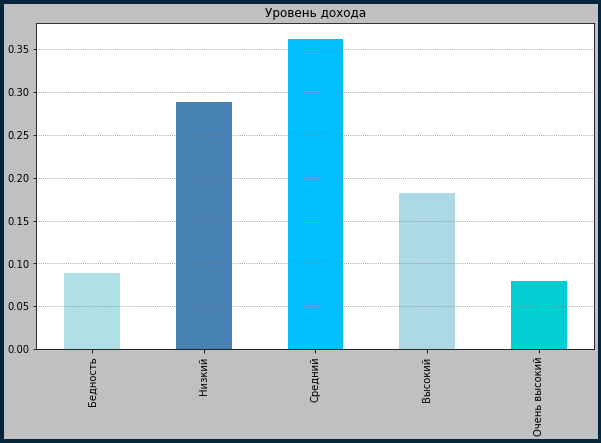

In [214]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

not_group_resp_income.plot.bar(color=colors)

plt.title('Уровень дохода')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**

> Распределение разных уровней дохода близко к нормальному.


## Анализ уровня образования

In [215]:
def resp_edu_group(x):
  d = {1: "Полное среднее и ниже",
       2: "Среднее спец-ное/техническое\nили нач-ное профес-ное",
       3: "Высшее и незаконченное высшее"}
  return d[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [216]:
not_resp_edu = not_victims["resp_edu"].dropna().sort_values() \
                              .apply(resp_edu_group)

print("Выборка содержит", len(not_resp_edu), "строк")

Выборка содержит 3527 строк


Посчитаем процентное содержание каждой категории в выборке

In [217]:
not_group_resp_edu = not_resp_edu.value_counts(1). \
                    reindex(resp_edu.unique())

print("Среди пострадавших:")
for i in range(len(not_group_resp_edu)):
  print("{:<13} - {:.3f}%".format(not_group_resp_edu.index[i],
                                  not_group_resp_edu[i] * 100))

Среди пострадавших:
Полное среднее и ниже - 23.249%
Среднее спец-ное/техническое
или нач-ное профес-ное - 38.616%
Высшее и незаконченное высшее - 38.134%


Построим по полученным значениям график.

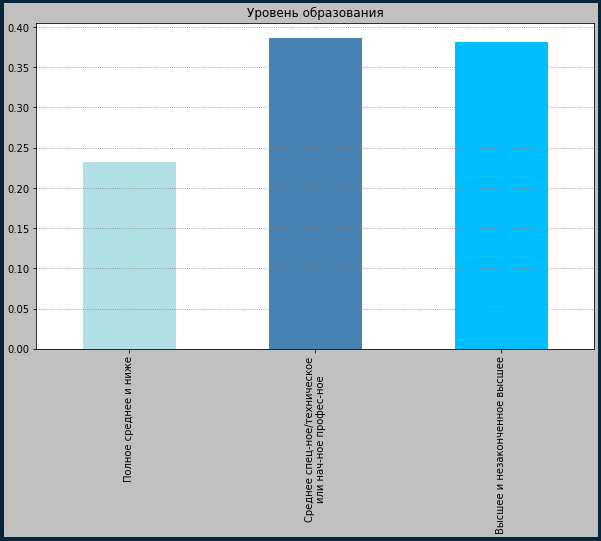

In [218]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

not_group_resp_edu.plot.bar(color=colors)

plt.title('Уровень образования')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**

> Среди лиц, не подвергавшихся преступлениям, меньше всего лиц с полным средним и более низким уровнем образования.

> Людей со средним спец-ным/техническим или нач-ным профес-ным образованием чуть больше, чем людей с высшим и незаконченным высшим образованием.

## Анализ социально–экономического статуса

In [219]:
def resp_ses_rename(x):
    d = {1.0: "Безработный",
         2.0: "Пенсионер",
         3.0: "Студент",
         4.0: "Рабочий",
         5.0: "Служащий",
         6.0: "Руководитель"}
    return d[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [220]:
not_resp_ses = not_victims["resp_ses"].dropna().sort_values().apply(resp_ses_rename)

print("Выборка содержит", len(not_resp_ses), "строк")

Выборка содержит 3719 строк


Посчитаем процентное содержание каждой категории в выборке

In [221]:
not_group_resp_ses = not_resp_ses.value_counts(1).sort_values()

print("Среди пострадавших:")
for i in range(len(not_group_resp_ses)):
  print("{:<13} - {:.3f}%".format(not_group_resp_ses.index[i],
                                  not_group_resp_ses[i] * 100))

Среди пострадавших:
Студент       - 7.421%
Руководитель  - 13.606%
Безработный   - 16.053%
Служащий      - 16.617%
Рабочий       - 20.543%
Пенсионер     - 25.760%


Построим по полученным значениям график.


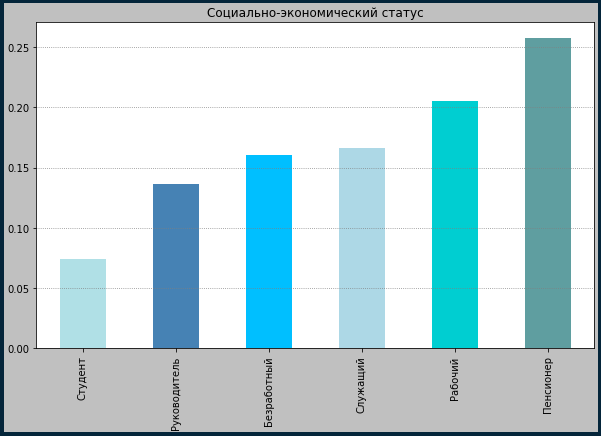

In [222]:
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

not_group_resp_ses.plot.bar(color=colors)

plt.title('Социально-экономический статус')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**

> Среди лиц, которые не подвергались преступлениям, меньше всего студентов, далее процентная составляющая каждой группы увеличивается

## Составим идеальный портрет человека, не являющегося жертвой преступления

> **Женщина**

> **25-34 года**

> **Средний Уровень дохода**

> **Среднее специальное\техническое или научное профессиональное образование**

> **Социально-экономический статус — рабочий**


# Сравнение выборок из лиц, являющихся жертвами преступлений и лиц, не являющихся жертвами преступлений

## Сравнение по половому признаку

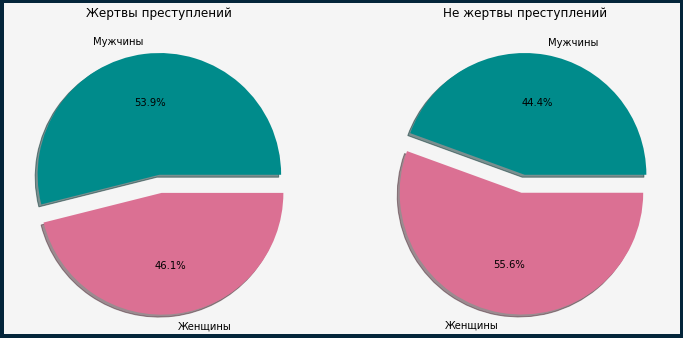

In [223]:
plt.figure(figsize=(12, 8), linewidth=8, edgecolor="#04253a") \
.set_facecolor(digclr)

ax = plt.subplot(1, 2, 1)
ax.pie(victim_count,  labels=["Мужчины", "Женщины"],
       colors=('darkcyan', 'palevioletred'),
      explode=(0, 0.15),
        shadow=True, autopct='%1.1f%%')
ax.set_title("Жертвы преступлений")
ax.grid(which='major', color = 'gray', axis='y', linestyle=':')

ax = plt.subplot(1, 2, 2)
ax.pie(not_victim_count[::-1],  labels=["Мужчины", "Женщины"],
       colors=('darkcyan', 'palevioletred'),
      explode=(0, 0.15),
        shadow=True, autopct='%1.1f%%')
ax.set_title("Не жертвы преступлений")
ax.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**

> Среди жертв преступлений преобладают мужчины, в то время в выборке лиц, не являющихся жертвами преступлений, преобладают женщины

## Сравнение по возрасту

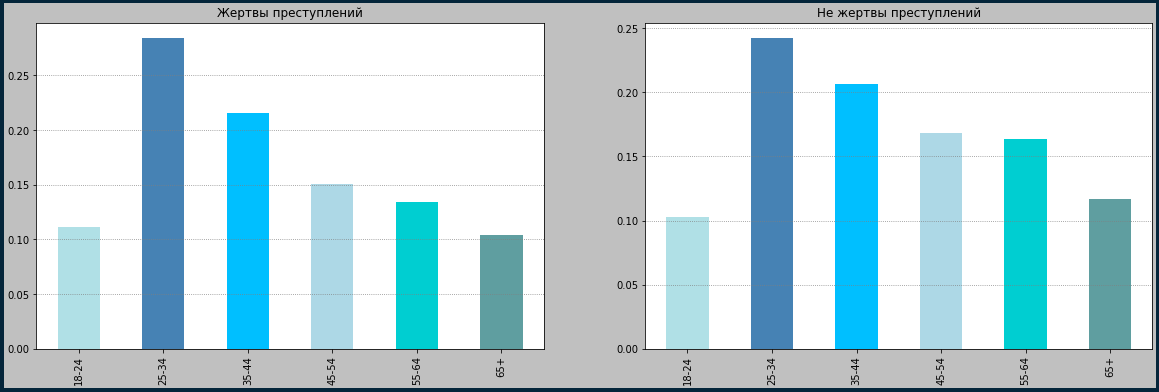

In [224]:
# Красивые графики
plt.figure(figsize=(20, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

ax = plt.subplot(1, 2, 1)
group_resp_age.plot.bar(color=colors)
plt.title('Жертвы преступлений')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

ax = plt.subplot(1, 2, 2)
not_group_resp_age.plot.bar(color=colors)
plt.title('Не жертвы преступлений')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**

> Обе выборки имеют схожее распределение.

> В выборке жертв преступлений значительно больше процент лиц категории "25-34".

> В выборке людей, не являющихся жертвами преступлений, больше процент категорий "45-54", "55-64" и "65+"



## Сравнение по уровню дохода

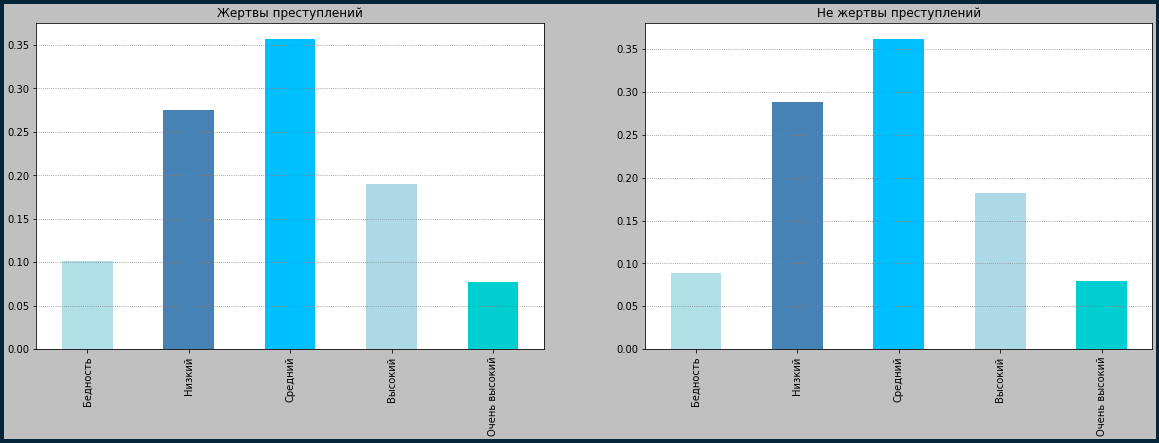

In [225]:
# Красивые графики
plt.figure(figsize=(20, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

ax = plt.subplot(1, 2, 1)
group_resp_income.plot.bar(color=colors)
plt.title('Жертвы преступлений')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

ax = plt.subplot(1, 2, 2)
not_group_resp_income.plot.bar(color=colors)
plt.title('Не жертвы преступлений')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**

> Процентное содержание каждой категории уровня дохода примерно схоже в обоих выборках

## Сравнение по уровню образования

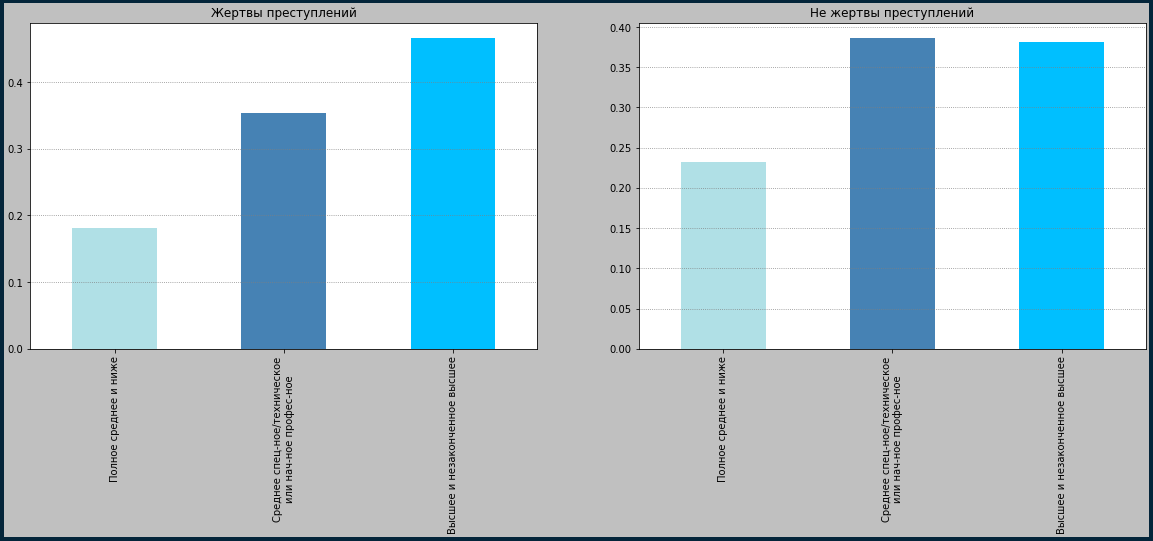

In [226]:
# Красивые графики
plt.figure(figsize=(20, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

ax = plt.subplot(1, 2, 1)
group_resp_edu.plot.bar(color=colors)
plt.title('Жертвы преступлений')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

ax = plt.subplot(1, 2, 2)
not_group_resp_edu.plot.bar(color=colors)
plt.title('Не жертвы преступлений')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**

> В выборке лиц, ставших жертвами преступлений, значительно меньше лиц с образованием уровней "полное среднее и ниже" и "среднее спец-ное/техническое или нач-ное профес-ное"


> В выборке лиц, не являющихся жертвами преступлений, значительно меньше людей с высшим и незаконченным высшим образованием


## Сравнение по социально–экономическому статусу

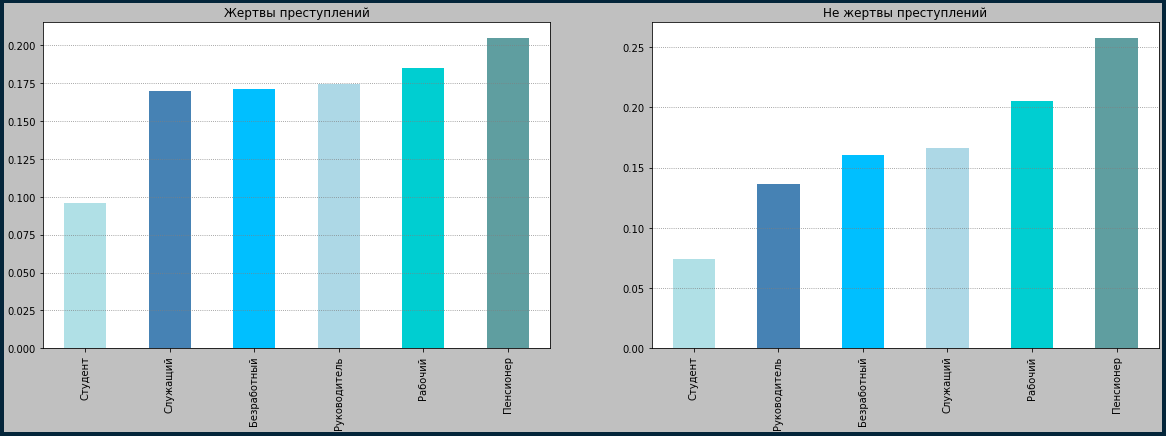

In [227]:
plt.figure(figsize=(20, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

ax = plt.subplot(1, 2, 1)
group_resp_ses.plot.bar(color=colors)
plt.title('Жертвы преступлений')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

ax = plt.subplot(1, 2, 2)
not_group_resp_ses.plot.bar(color=colors)
plt.title('Не жертвы преступлений')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**

> В выборке жертв преступлений процентное содержание студентов, чем в выборке лиц, которые не становились жертвами преступлений.

> В выборке жертв преступлений процентное содержание служащих, безработных, руководителей и рабочих примерно одинаково и больше, чем в другой выборке.

> В выборке людей, не являющихся жертвами преступлений, значительно больше пенсионеров.

## Общий вывод из сравнения выборок

> **Наибольшее влияние на вероятность стать жертвой преступления оказывают пол, образование и социально-экономический статус**

# Классификационная модель
##### Исходя из полученных нами данных в результате исследования зависимости влияния социально-демографических характеристик человека на его подверженность преступлению, было принято решение построить классификационную модель, предсказывающую вероятность стать жертвой преступления (целевой признак – **resp_is_crime_victim**) исходя из 4 категориальных признаков:
*   **resp_is_male** – пол жертвы преступления
*   **resp_age** – возрастная категория, к которой относится респондент
*   **resp_edu** – уровень образования респондента
*   **resp_income** – уровень дохода опрошенного
*   **resp_ses** - социально-экономический статус респондента

Для этого была выбрана библиотека **CatBoost** – открытая программная библиотека, разработанная компанией **Яндекс** и реализующая уникальный патентованный алгоритм построения моделей машинного обучения, использующий одну из оригинальных схем градиентного бустинга, включающая в себя классификационную модель **CatBoostClassifier**.



### **<font color='red'>Внимание</font>**
Для построения графиков к классификационной модели использовались встроенные методы библиотеки **CatBoost**, для их корректного отображения необходимо установить и включить виджеты **IPywidgets**. Вследствие чего **просьба произвести запуск всех ячеек данного ноутбука**

## Создание необходимых выборок

Для начала создадим выборку из выбранных для обучения столбцов

In [228]:
from sklearn.model_selection import train_test_split

forcatbst = df[["resp_is_male", "resp_age", "resp_edu", "resp_income", "resp_ses", "resp_is_crime_victim"]]

forcatbst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16818 entries, 0 to 16817
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   resp_is_male          16818 non-null  int64  
 1   resp_age              16818 non-null  int64  
 2   resp_edu              6528 non-null   float64
 3   resp_income           6319 non-null   float64
 4   resp_ses              6720 non-null   float64
 5   resp_is_crime_victim  16818 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 788.5 KB


Теперь разделим полученную выборку на тестовую и тренировочную

In [229]:
train_cat, test_cat = train_test_split(forcatbst, train_size=0.75, random_state=42)

Заменим пропущенные значения для корректного обучения модели

In [230]:
train_cat.fillna(-999, inplace=True)
test_cat.fillna(-999, inplace=True)

Разделим тренировочную выборку на признаки и целевой признак

In [231]:
X = train_cat.drop("resp_is_crime_victim", axis=1)
y = train_cat.resp_is_crime_victim

Разделим полученные выборки на тренировочные и валидационные

In [232]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = test_cat

Для последующего обучения модели необходимо создать переменную, содержащую индексы столбцов, чей тип отличен от **float64**

In [233]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

print(X.dtypes)
print("Индексы столбцов, чей тип отличен от float64 - {} и {}".format(*categorical_features_indices))

resp_is_male      int64
resp_age          int64
resp_edu        float64
resp_income     float64
resp_ses        float64
dtype: object
Индексы столбцов, чей тип отличен от float64 - 0 и 1


## Создание модели

Создадим модель **CatBoostClassifier** с рекомендуемыми разработчиками модели параметрами

In [234]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    eval_metric='Accuracy',
    logging_level='Silent',
    random_state=696969,
    use_best_model=True,
    iterations=300,
    boosting_type='Ordered'
)

## Обучение модели

Обучим нашу модель на тренировочной выборке, используя рекомендуемые разработчиками параметры, а также построим график точности модели по мере её обучения

In [235]:
model = model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Расчет точности модели и кросс–валидация

Произведем кросс-валидацию модели и построим график

In [236]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Построим график точности модели по мере её применения к валидационной выборке

In [237]:
validation_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)
eval_metrics = model.eval_metrics(validation_pool, ['Accuracy'], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Для того, чтобы получить истинное значение, расчитаем среднее точности

In [238]:
print('Истинное значение точности модели: {:.3f}%'.format(np.max(cv_data['test-Accuracy-mean']) * 100))

Истинное значение точности модели: 82.431%


> **Теперь у нас есть модель, способная предсказать, будет ли человек являться жертвой преступления**

## Применение модели к случайным данным

Применим модель к случайным данным, для этого создадим датасет с произвольными значениями

In [239]:
from random import randint

columns = ["Пол", "Возраст", "Образование", "Доход", "Социально-экономический статус"]

random_data = pd.DataFrame(columns=columns)

for i in range(10):
    random_data.loc[i] = [randint(0, 1), randint(18, 100), randint(1, 3), randint(1, 5), randint(1, 6)]
    
random_data

,Пол,Возраст,Образование,Доход,Социально-экономический статус
0,1,83,2,5,6
1,0,28,3,4,3
2,1,47,1,2,5
3,0,34,1,5,4
4,1,48,1,3,6
5,0,28,1,4,1
6,1,69,1,1,3
7,1,30,2,1,3
8,0,43,1,4,1
9,1,78,2,4,4


Теперь применим к нему нашу модель

In [240]:
def pred_rename(x):
    return "Да" if x else "Нет"

preds, prob_y, prob_n = [], [], []

columns = ["Пол", "Образование", "Доход", "Социально-экономический статус", "Предсказание"]

for i in range(len(random_data)):
    preds.append(model.predict(list(random_data.loc[i])))
    probs = model.predict_proba(list(random_data.loc[i]))
    prob_n.append("{:.2f}%".format(probs[0] * 100))
    prob_y.append("{:.2f}%".format(probs[1] * 100))

random_data["Предсказание"] = preds
random_data['Вероятность "Нет"'] = prob_n
random_data['Вероятность "Да"'] = prob_y

func_lst = [ifmale, resp_edu_group,  income, resp_ses_rename, pred_rename]

for column, func in zip(columns, func_lst):
    random_data[column] = random_data[column].apply(func)

random_data

,Пол,Возраст,Образование,Доход,Социально-экономический статус,Предсказание,"Вероятность ""Нет""","Вероятность ""Да"""
0,Мужчина,83,Среднее спец-ное/техническое\nили нач-ное проф...,Очень высокий,Руководитель,Нет,54.31%,45.69%
1,Женщина,28,Высшее и незаконченное высшее,Высокий,Студент,Да,49.85%,50.15%
2,Мужчина,47,Полное среднее и ниже,Низкий,Служащий,Нет,56.11%,43.89%
3,Женщина,34,Полное среднее и ниже,Очень высокий,Рабочий,Нет,63.56%,36.44%
4,Мужчина,48,Полное среднее и ниже,Средний,Руководитель,Нет,56.81%,43.19%
5,Женщина,28,Полное среднее и ниже,Высокий,Безработный,Да,49.48%,50.52%
6,Мужчина,69,Полное среднее и ниже,Бедность,Студент,Нет,55.23%,44.77%
7,Мужчина,30,Среднее спец-ное/техническое\nили нач-ное проф...,Бедность,Студент,Нет,58.12%,41.88%
8,Женщина,43,Полное среднее и ниже,Высокий,Безработный,Нет,53.90%,46.10%
9,Мужчина,78,Среднее спец-ное/техническое\nили нач-ное проф...,Высокий,Рабочий,Да,49.87%,50.13%


## Применение модели к идеальным портретам лиц, являющихся и не являющихся жертвами преступлений

Попробуем применить нашу модель к идеальным портретам лиц, являющихся и не являющихся жертвами преступлений

In [241]:
ideal_victim = [1, 30, 3, 3, 4]
ideal_not_victim = [0, 30, 2, 3, 4]

print("Предсказание для идеального портрета человека, являющегося жертвой преступления - {}"
      .format("Да" if model.predict(ideal_victim) else "Нет"))
print("Предсказание для идеального портрета человека, не являющегося жертвой преступления - {}"
      .format("Да" if model.predict(ideal_not_victim) else "Нет"))

Предсказание для идеального портрета человека, являющегося жертвой преступления - Да
Предсказание для идеального портрета человека, не являющегося жертвой преступления - Нет


> **Как мы видим, наша модель сделала правильное предсказание в обоих случаях, что ещё раз доказывает её точность**

## Вывод по построению классификационной модели

> **Нам удалось построить модель, способную предcказать, окажется ли человек жертвой преступления, с точностью 82.431%**

# Результаты проделанной работы

> **Была выполнена предварительная обработка данных**

> **Определены и визуализированы закономерности и корреляции признаков**

> **Найдены параметры, по которым можно определить группу людей, наиболее подверженных преступлениям**

> **Найдены параметры, по которым можно определить группу людей, наименее подверженных преступлениям**

> **Были определены признаки, которые оказывают наибольшее влияние на вероятность оказаться жертвой преступления**

> **Построена классификационная модель, с помощью которой можно предсказать вероятность оказаться жертвой преступления для определенного лица**